In [1]:
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt

In [47]:
# Load storm event data (LBC results, for sewer subsection only)
# WRRF flow is in units of cubic feet/sec
# WRRF TSS load is in units of lb/sec
# WRRF TSS concentration is in units of mg/L
storm_nocontrol = np.load('../data/storm2.npy', allow_pickle=True)
storm_control = np.load('../data/storm2_control_both.npy', allow_pickle=True)

# 0 if saving no control results; 1 if saving control results
save = 1

if save == 0:
    storm = cp.deepcopy(storm_nocontrol)
    file_c = 'nc'
else:
    storm = cp.deepcopy(storm_control)
    file_c = 'c'

# File name for influent tsv
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/data/storm2_'+file_c+'_influent.tsv'

In [48]:
# Check storm event data contents
storm

array({'time': array([[35.],
       [35.],
       [35.],
       ...,
       [53.],
       [53.],
       [53.]], dtype=float16), 'WRRF_flow': array([[201.25288],
       [201.25253],
       [201.25218],
       ...,
       [200.67503],
       [200.67487],
       [200.67471]], dtype=float32), 'WRRF_TSSLoad': array([[1.9980607],
       [1.9981285],
       [1.9981964],
       ...,
       [1.9971652],
       [1.997234 ],
       [1.997303 ]], dtype=float32), 'WRRF_TSSConc': array([[158.98814193],
       [158.99381471],
       [158.99950394],
       ...,
       [159.37449939],
       [159.38012285],
       [159.3857463 ]]), 'WRRF_flow_dry': array([230.26028442, 230.25498962, 230.24963379, ..., 216.78005981,
       216.77957153, 216.77909851]), 'WRRF_TSSLoad_dry': array([2.13773823, 2.13777018, 2.13780141, ..., 2.06743383, 2.06750274,
       2.06757188]), 'WRRF_flow_wet': array([-29.00740051, -29.00245667, -28.99745178, ..., -16.10502625,
       -16.10470581, -16.10438538]), 'WRRF_TSSLoad_wet': 

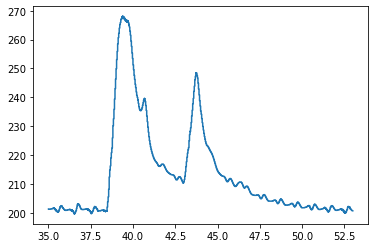

In [49]:
# Flow in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_flow'))

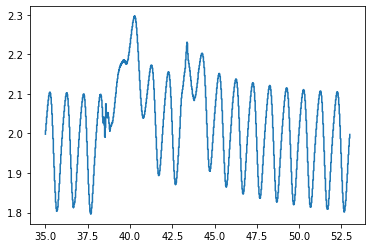

In [50]:
# TSS load in sewer subsection (only)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSLoad'))

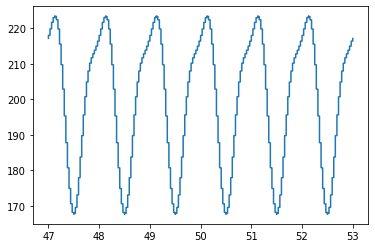

In [51]:
# Plot section that is dry-weather only
# Will average over this section to get dry-weather average value
dw_start = 12*24*60*60/10
dw_end = -1
plt.plot(storm_nocontrol.item().get('time')[int(dw_start):int(dw_end)],storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

seweroutflow = np.mean(storm_nocontrol.item().get('WRRF_flow')[int(dw_start):int(dw_end)])

In [52]:
# Using ./data/flowPrecip.xlsx average dry-weather WRRF inflow is about 520.30 Mgal/d (1.9695 Mm3/d)
### OLD Average WRRF inflow is 2,788,860 m3/d
# Converting m3/d to cubic feet/sec ...
WRRFinflow = 1969500 * 35.3147 / 86400

In [53]:
# Ratio to scale from sewer subsection to GLWA WRRF influent
scale_ratio = WRRFinflow/seweroutflow
scale_ratio

4.021942683350994

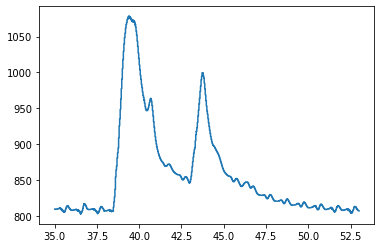

In [54]:
# Flow for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_flow'))

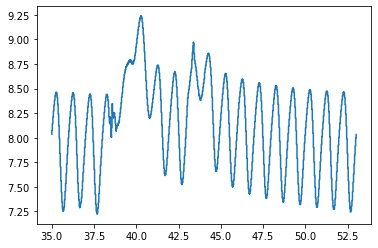

In [55]:
# TSS load for GLWA WRRF influent
plt.plot(storm.item().get('time'),scale_ratio*storm.item().get('WRRF_TSSLoad'))

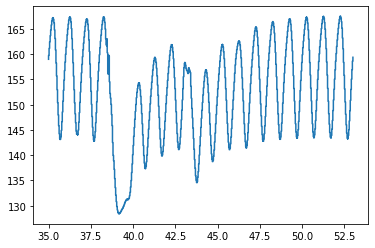

In [56]:
# TSS concentration for GLWA WRRF influent (same as that for sewer subsection since concentration)
plt.plot(storm.item().get('time'),storm.item().get('WRRF_TSSConc'))

In [57]:
# Using GLWA WRRF model, ...
# influent TP is 2.2 mg P/L, 
# fraction of PO4 in total phosphorus is 53.3%, so influent SP is 1.1726 mg P/L, 
# influent PP (particular phosphorus) is 1.0274 mg P/L

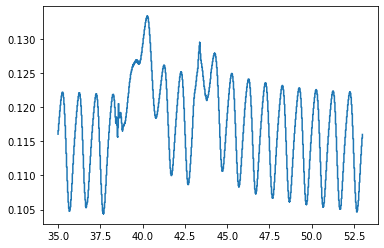

In [58]:
# For current simplification, phosphorus will only include total phosphorus without fractionation
# and will mirror TSS dynamics

# TP concentration in mg/L
WRRF_TPConc = storm.item().get('WRRF_TSSConc') / np.mean(storm.item().get('WRRF_TSSConc')) * 2.2

# TP load in lb/sec for GLWA WRRF influent
WRRF_TPLoad = np.multiply(WRRF_TPConc,scale_ratio*storm.item().get('WRRF_flow')) * 2.205 / (10**6) * 28.32

# TP load for GLWA WRRF influent
plt.plot(storm.item().get('time'),WRRF_TPLoad)

In [59]:
storm_df = pd.DataFrame(data=np.column_stack((storm.item().get('time'),
                                        scale_ratio*storm.item().get('WRRF_flow'),
                                        scale_ratio*storm.item().get('WRRF_TSSLoad'),
                                        storm.item().get('WRRF_TSSConc'),
                                        WRRF_TPLoad,
                                        WRRF_TPConc)),
                  columns=['time',
                           'WRRF_flow',
                           'WRRF_TSSLoad',
                           'WRRF_TSSConc',
                           'WRRF_TPLoad',
                           'WRRF_TPConc'])
storm_df

,time,WRRF_flow,WRRF_TSSLoad,WRRF_TSSConc,WRRF_TPLoad,WRRF_TPConc
0,35.0,809.427551,8.036085,158.988142,0.116068,2.296324
1,35.0,809.426147,8.036358,158.993815,0.116072,2.296406
2,35.0,809.424744,8.036632,158.999504,0.116076,2.296488
3,35.0,809.423340,8.036904,159.005160,0.116080,2.296570
4,35.0,809.421936,8.037177,159.010833,0.116084,2.296652
...,...,...,...,...,...,...
155515,53.0,807.104797,8.031930,159.363236,0.116008,2.301742
155516,53.0,807.104126,8.032207,159.368859,0.116012,2.301823
155517,53.0,807.103455,8.032484,159.374499,0.116016,2.301905
155518,53.0,807.102783,8.032761,159.380123,0.116020,2.301986


In [60]:
with open(w_influentTSV,'w') as write_tsv:
    write_tsv.write(storm_df.to_csv(sep='\t', index=False))